<a href="https://colab.research.google.com/github/jonatas06ap/Reducao_de_dimensionalidade_imagens/blob/main/reducao_dimensionalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convertendo uma imagem para tons de cinza e pata preto e branco

Importando a imagem

In [4]:
from google.colab import files
upload = files.upload()


Saving WhatsApp Image 2025-08-30 at 14.28.36 (Cópia).jpeg to WhatsApp Image 2025-08-30 at 14.28.36 (Cópia).jpeg


Extraindo o bit map

In [5]:
from PIL import Image
import os

# Caminho para o seu arquivo de imagem original (pode ser .jpg, .png, etc.)
caminho_original = "patinho.jpeg"

# Define o nome do novo arquivo BMP
caminho_bmp = "patinho.bmp"

try:
    # Abre a imagem
    imagem = Image.open(caminho_original)

    #Convertendo

    imagem.save(caminho_bmp)

    print(f"Imagem '{caminho_original}' convertida e salva como '{caminho_bmp}' com sucesso!")

except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_original}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao converter a imagem: {e}")

Imagem 'patinho.jpeg' convertida e salva como 'patinho.bmp' com sucesso!


Lendo os bits da imagem

In [7]:
import struct

def ler_bmp(caminho_arquivo):

    with open(caminho_arquivo, 'rb') as arquivo:
        # Lê o cabeçalho do arquivo (14 bytes)
        # O offset para os dados dos pixels está no byte 10

        arquivo.seek(10)
        offset_dados, = struct.unpack('<I', arquivo.read(4))

        # Lê o tamanho do cabeçalho da imagem (4 bytes)

        arquivo.seek(14)
        tamanho_cabecalho, = struct.unpack('<I', arquivo.read(4))

        # Lê o restante do cabeçalho da imagem

        if tamanho_cabecalho == 40:
            arquivo.seek(18)
            largura, altura = struct.unpack('<ii', arquivo.read(8))
            arquivo.seek(28)
            profundidade_bits, = struct.unpack('<H', arquivo.read(2))
        else:
            raise ValueError(f"Cabeçalho da imagem com tamanho inesperado: {tamanho_cabecalho} bytes.")

        if profundidade_bits != 24:
            raise ValueError("Este script suporta apenas BMPs de 24 bits.")

        print(f"Largura: {largura}, Altura: {altura}, Profundidade: {profundidade_bits} bits")

        # Pula para o início dos dados dos pixels

        arquivo.seek(offset_dados)

        # O padding é necessário para garantir que as linhas de pixels tenham um número de bytes divisível por 4
        padding = (4 - (largura * 3) % 4) % 4

        dados_pixels = []
        for y in range(altura):
            linha = []
            for x in range(largura):
                b, g, r = struct.unpack('<BBB', arquivo.read(3))
                linha.append((r, g, b))
            dados_pixels.append(linha)
            # Pula o padding no final de cada linha
            arquivo.seek(padding, 1)

    return dados_pixels, largura, altura

# Uso
caminho_do_arquivo = "patinho.bmp"
try:
    dados_pixels, largura, altura = ler_bmp(caminho_do_arquivo)

    # Teste
    pixel = dados_pixels[20][10]
    print(f"Pixel na posição (10, 20): R={pixel[0]}, G={pixel[1]}, B={pixel[2]}")

except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_do_arquivo}' não foi encontrado.")
except ValueError as e:
    print(f"Erro: {e}")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo: {e}")

Largura: 178, Altura: 179, Profundidade: 24 bits
Pixel na posição (10, 20): R=195, G=167, B=128


Convertendo o bitmap para tons de cinza e preto e branco

In [17]:
import struct

def converter_bmp(caminho_entrada, caminho_saida_cinza, caminho_saida_pb, limiar):
    try:
        with open(caminho_entrada, 'rb') as arquivo_entrada:
            # === Leitura dos cabeçalhos ===
            cabecalho_arquivo = arquivo_entrada.read(14)
            cabecalho_imagem = arquivo_entrada.read(40)

            largura, = struct.unpack('<i', cabecalho_imagem[4:8])
            altura, = struct.unpack('<i', cabecalho_imagem[8:12])
            profundidade_bits, = struct.unpack('<H', cabecalho_imagem[14:16])
            offset_dados, = struct.unpack('<I', cabecalho_arquivo[10:14])

            if profundidade_bits != 24:
                print("Erro: O script suporta apenas BMPs de 24 bits.")
                return

            print(f"Imagem original - Largura: {largura}, Altura: {altura}, Profundidade: {profundidade_bits} bits")

            # === Processamento dos pixels ===
            arquivo_entrada.seek(offset_dados)

            # Cálculo do padding: importante para leitura e escrita
            padding = (4 - (largura * 3) % 4) % 4

            dados_pixels_cinza = bytearray()
            dados_pixels_pb = bytearray()

            for _ in range(altura):
                for _ in range(largura):
                    b, g, r = struct.unpack('<BBB', arquivo_entrada.read(3))

                    # Conversão para tons de cinza
                    pixel_cinza = int(0.299 * r + 0.587 * g + 0.114 * b)

                    # Conversão para P&B com limiar
                    if pixel_cinza > limiar:
                        pixel_pb = 255
                    else:
                        pixel_pb = 0

                    # Adiciona os pixels convertidos (BGR)
                    dados_pixels_cinza.extend([pixel_cinza, pixel_cinza, pixel_cinza])
                    dados_pixels_pb.extend([pixel_pb, pixel_pb, pixel_pb])

                # Pula o padding original e adiciona o novo padding
                arquivo_entrada.seek(padding, 1)
                dados_pixels_cinza.extend([0] * padding)
                dados_pixels_pb.extend([0] * padding)

        # === Escrita dos novos arquivos BMP ===
        with open(caminho_saida_cinza, 'wb') as arquivo_cinza:
            arquivo_cinza.write(cabecalho_arquivo)
            arquivo_cinza.write(cabecalho_imagem)
            arquivo_cinza.write(dados_pixels_cinza)
            print(f"Imagem salva como '{caminho_saida_cinza}' com sucesso.")

        with open(caminho_saida_pb, 'wb') as arquivo_pb:
            arquivo_pb.write(cabecalho_arquivo)
            arquivo_pb.write(cabecalho_imagem)
            arquivo_pb.write(dados_pixels_pb)
            print(f"Imagem salva como '{caminho_saida_pb}' com sucesso.")

    except FileNotFoundError:
        print("Erro: Arquivo de entrada não encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro: {e}")

# --- Exemplo de uso ---
caminho_original = "patinho.bmp"
caminho_cinza = "patinho_cinza_final.bmp"
caminho_pb = "patinho_pb_final.bmp"

converter_bmp(caminho_original, caminho_cinza, caminho_pb, 96)

Imagem original - Largura: 178, Altura: 179, Profundidade: 24 bits
Imagem salva como 'patinho_cinza_final.bmp' com sucesso.
Imagem salva como 'patinho_pb_final.bmp' com sucesso.


Exibindo as imagens

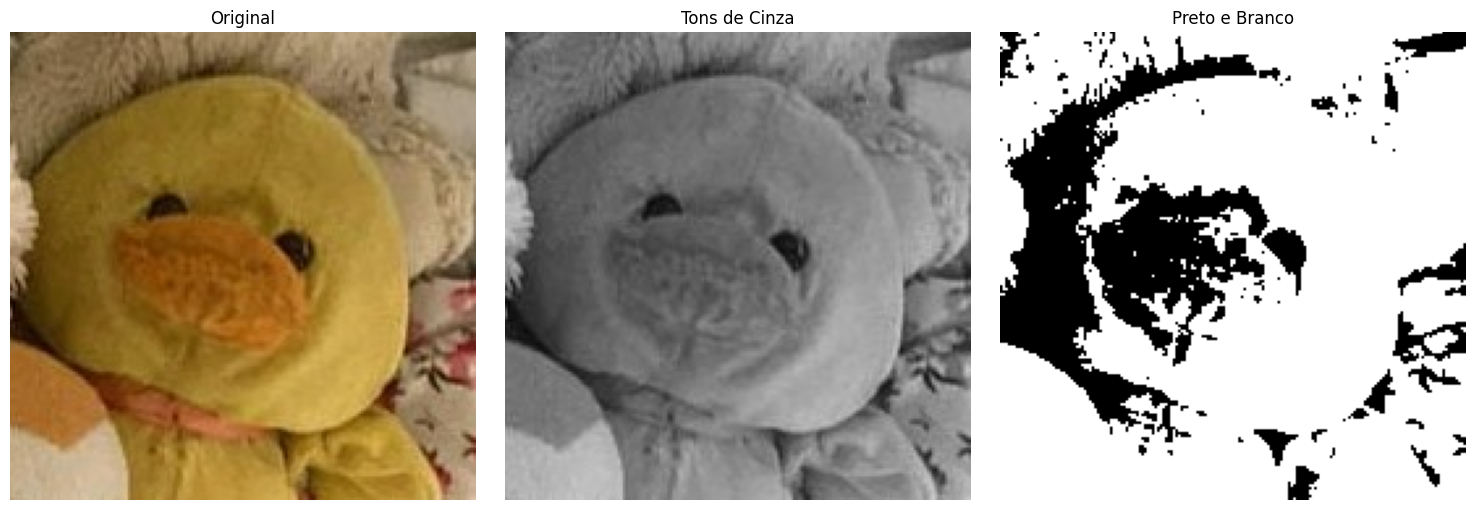

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

def exibir_imagens_no_notebook(caminho_original, caminho_cinza, caminho_pb):
    """
    Exibe três imagens lado a lado usando Matplotlib.
    """
    try:
        # Abre as imagens
        img_original = Image.open(caminho_original)
        img_cinza = Image.open(caminho_cinza)
        img_pb = Image.open(caminho_pb)

        # Cria uma figura com 3 subplots para as imagens
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Exibe a imagem original no primeiro subplot
        axes[0].imshow(img_original)
        axes[0].set_title('Original')
        axes[0].axis('off')  # Desliga os eixos

        # Exibe a imagem em tons de cinza no segundo subplot
        axes[1].imshow(img_cinza, cmap='gray')
        axes[1].set_title('Tons de Cinza')
        axes[1].axis('off')

        # Exibe a imagem em preto e branco no terceiro subplot
        axes[2].imshow(img_pb, cmap='gray')
        axes[2].set_title('Preto e Branco')
        axes[2].axis('off')

        # Ajusta o layout para evitar sobreposição
        plt.tight_layout()
        # Exibe a figura no notebook
        plt.show()

    except FileNotFoundError:
        print("Erro: Um ou mais arquivos de imagem não foram encontrados.")
    except Exception as e:
        print(f"Ocorreu um erro ao exibir as imagens: {e}")

# --- Exemplo de uso ---
caminho_original = "patinho.bmp"
caminho_cinza = "patinho_cinza_final.bmp"
caminho_pb = "patinho_pb_final.bmp"

exibir_imagens_no_notebook(caminho_original, caminho_cinza, caminho_pb)